# HW4 - MobileNet V1 and V2: A PyTorch Tutorial
[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Amirmahdi Meighani



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy


In [ ]:
# Enter your information here
first_and_last_name = 'Ghazal Zolfi Moselo'
std_number = '401104146'

![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [ ]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader

Check your device. We recommend using GPU. You can use GPU with google colab.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [ ]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0)
    x_normalized = (x - mean) / np.sqrt(variance + epsilon)
    y = gamma * x_normalized + beta

    return y

In [ ]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [ ]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# TODO: create train data loader without shuffle with just half of the data
train_subset_indices = list(range(len(train_set) // 2))
train_subset = Subset(train_set, train_subset_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=False, num_workers=2)

# VALIDATION DATA
val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# TODO: create test
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:17<00:00, 9.76MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Explain what we did in transfor train and tranform test:<br/>

---

### **`transform_train`:**

Transformations applied during the **training phase** are aimed at **data augmentation** to improve model generalization and robustness.

1. **`RandomResizedCrop(224, scale=(0.5, 1.0))`:**
   - Randomly crops a portion of the image and resizes it to \(224 \times 224\).
   - The crop's scale (size relative to the original) is chosen randomly between 50% and 100%.
   - **Purpose:** Adds variability to the training data, simulating different zoom levels or perspectives.

2. **`RandomHorizontalFlip()`:**
   - Randomly flips the image horizontally.
   - **Purpose:** Introduces variability in image orientation, making the model less sensitive to left-right directionality.

3. **`ToTensor()`:**
   - Converts the image from a PIL image or NumPy array to a PyTorch tensor (a numerical array compatible with PyTorch models).
   - **Purpose:** Converts data to a format usable by PyTorch models.

4. **`Normalize(mean, std)`:**
   - Adjusts the image pixel values for each color channel (R, G, B) by:
     - Subtracting the channel's mean.
     - Dividing by the channel's standard deviation.
   - **Purpose:** Centers and scales the pixel values, helping the model converge faster during training by ensuring that the input values are in a consistent range.

---

### **`transform_test`:**

Transformations applied during the **testing (or validation) phase** ensure that the model receives input data in a consistent format without introducing randomness.

1. **`Resize((224, 224))`:**
   - Resizes the image to a fixed size of \(224 \times 224\) without cropping or random scaling.
   - **Purpose:** Ensures all test images have a consistent size for evaluation.

2. **`ToTensor()`:**
   - Converts the image to a PyTorch tensor, similar to the training phase.

3. **`Normalize(mean, std)`:**
   - Normalizes the image pixel values using the same mean and standard deviation as in the training phase.
   - **Purpose:** Ensures consistency in data preprocessing between training and testing.

---

### **Purpose of These Transforms:**

- **Training Transforms:** Enable the model to learn robust features by exposing it to diverse variations of the data.
- **Testing Transforms:** Ensure reliable and reproducible evaluation of the model by standardizing input preprocessing.

for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

In [ ]:
transform_train_no_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

train_set_no_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_no_aug)

train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified


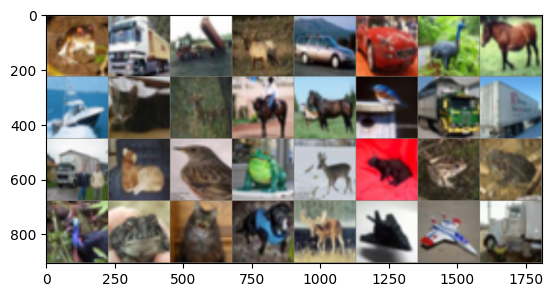

Labels are tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9])


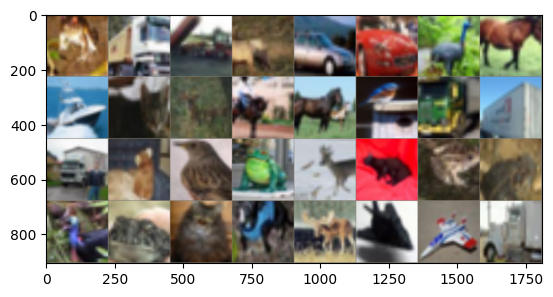

In [ ]:
def imshow(img):
    # TODO:
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

# show some training images with shuffle=False and labels
data_iter = iter(train_loader_no_aug)
images, labels = next(data_iter)
grid_img = torchvision.utils.make_grid(images[:32], nrow=8)
imshow(grid_img)
print("Labels are", labels)

# show them again to check the augmentation
data_iter = iter(train_loader)
images, labels = next(data_iter)
grid_img_2 = torchvision.utils.make_grid(images[:32], nrow=8)
imshow(grid_img_2)

# create train loader with shuffle true
train_loader_shuffle = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)

For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [ ]:
MODEL_SAVE_PATH = './model.pt'

# Assuming global variables 'device' and 'MODEL_SAVE_PATH' are defined elsewhere.
def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    losses = []
    model.train() if train_mode else model.eval()
    gradient_state = torch.enable_grad() if train_mode else torch.no_grad()

    with gradient_state:
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            if train_mode:
                optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            losses.append(loss.item())
            if train_mode:
                loss.backward()
                optimizer.step()
    return losses


def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_losses += fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        val_loss = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)
        val_losses.append(sum(val_loss) / len(val_loss))
        print(f"Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")
        torch.save(model.state_dict(), MODEL_SAVE_PATH)

    return train_losses, val_losses


def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    return correct / total


def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    train_loader_length,
    epochs
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    train_iterations = np.arange(len(train_losses))
    val_epochs = np.arange(1, epochs + 1) * train_loader_length

    plt.figure(figsize=(16, 6), dpi=200)
    plt.plot(train_iterations, train_losses, label="Training Loss")
    plt.plot(val_epochs, val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss and Validation Loss")
    plt.legend()
    plt.show()

Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [ ]:
def conv_bn(inp, oup, stride):
    # Define a standard convolutional layer with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the convolution
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True))

def conv_dw(inp, oup, stride):
    # Define a depthwise separable convolution layer
    # Consists of depthwise convolution followed by pointwise convolution, each with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the depthwise convolution
    return nn.Sequential(
        nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True))

Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.

---


#### 1. Standard Convolution

In a standard convolution, filters of size `K x K` are applied across all input channels simultaneously, and the results are mapped to the output channels.

**Number of Parameters:**
Parameters = K * K * Cin * Cout

Where:
- K x K: Filter size
- Cin: Number of input channels
- Cout: Number of output channels

---

#### 2. Depthwise Separable Convolution

Depthwise separable convolutions are divided into two steps:
1. **Depthwise Convolution:** Applies a `K x K` filter to each input channel independently.
2. **Pointwise Convolution:** Combines the output channels using a `1 x 1` convolution.

**Number of Parameters:**
Depthwise Parameters = K * K * Cin  
Pointwise Parameters = Cin * Cout  
Total Parameters = (K * K * Cin) + (Cin * Cout)

---

#### 3. Parameter Comparison

For example, with K=3, Cin=32, and Cout=64:

- **Standard Convolution:**
Parameters = 3 * 3 * 32 * 64 = 18,432

- **Depthwise Separable Convolution:**
Depthwise Parameters = 3 * 3 * 32 = 288  
Pointwise Parameters = 32 * 64 = 2,048  
Total Parameters = 288 + 2,048 = 2,336

**Reduction in Parameters:**
Reduction = (2,336 / 18,432) = ~0.13 (13%)

Depthwise separable convolutions reduce the number of parameters by approximately 87%.

---

#### 4. Speeding Up the Model

By reducing the number of parameters:
1. **Less Computation:** Fewer operations are required.
2. **Lower Memory Usage:** The model needs less memory.
3. **Faster Execution:** Ideal for mobile and embedded devices with limited resources.

---
Depthwise separable convolutions significantly reduce parameters and computations, making them highly efficient for lightweight models.

Now please create your model.

In [ ]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super(MobileNet, self).__init__()
        self.model = nn.Sequential(
            conv_bn(3, 32, stride=2),
            conv_dw(32, 64, stride=1),
            conv_dw(64, 128, stride=2),
            conv_dw(128, 128, stride=1),
            conv_dw(128, 256, stride=2),
            conv_dw(256, 256, stride=1),
            conv_dw(256, 512, stride=2),
            *[conv_dw(512, 512, stride=1) for _ in range(5)],
            conv_dw(512, 1024, stride=2),
            conv_dw(1024, 1024, stride=1),
            nn.AdaptiveAvgPool2d(1))
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [ ]:
epochs = 10
lr = 1e-3
# TODO:
batch_size = 128
model = MobileNet(n_class=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
train_loader_shuffle = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_no_shuffle = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

Get some metrics and plot your losses.

Epoch 1/10
Train Loss: 1.2815, Validation Loss: 1.2443
Epoch 2/10
Train Loss: 0.9607, Validation Loss: 0.9626
Epoch 3/10
Train Loss: 0.9268, Validation Loss: 0.7575
Epoch 4/10
Train Loss: 0.7282, Validation Loss: 0.8057
Epoch 5/10
Train Loss: 0.8659, Validation Loss: 0.6245
Epoch 6/10
Train Loss: 0.5101, Validation Loss: 0.6091
Epoch 7/10
Train Loss: 0.4158, Validation Loss: 0.5054
Epoch 8/10
Train Loss: 0.3360, Validation Loss: 0.5311
Epoch 9/10
Train Loss: 0.3270, Validation Loss: 0.4608
Epoch 10/10
Train Loss: 0.4065, Validation Loss: 0.4652

Batch_size=128, epochs=10, lr=0.001
Val accuracy =, 84.17%
Process Training time: 1811.7360 s
Process validation time: 18.6177 s


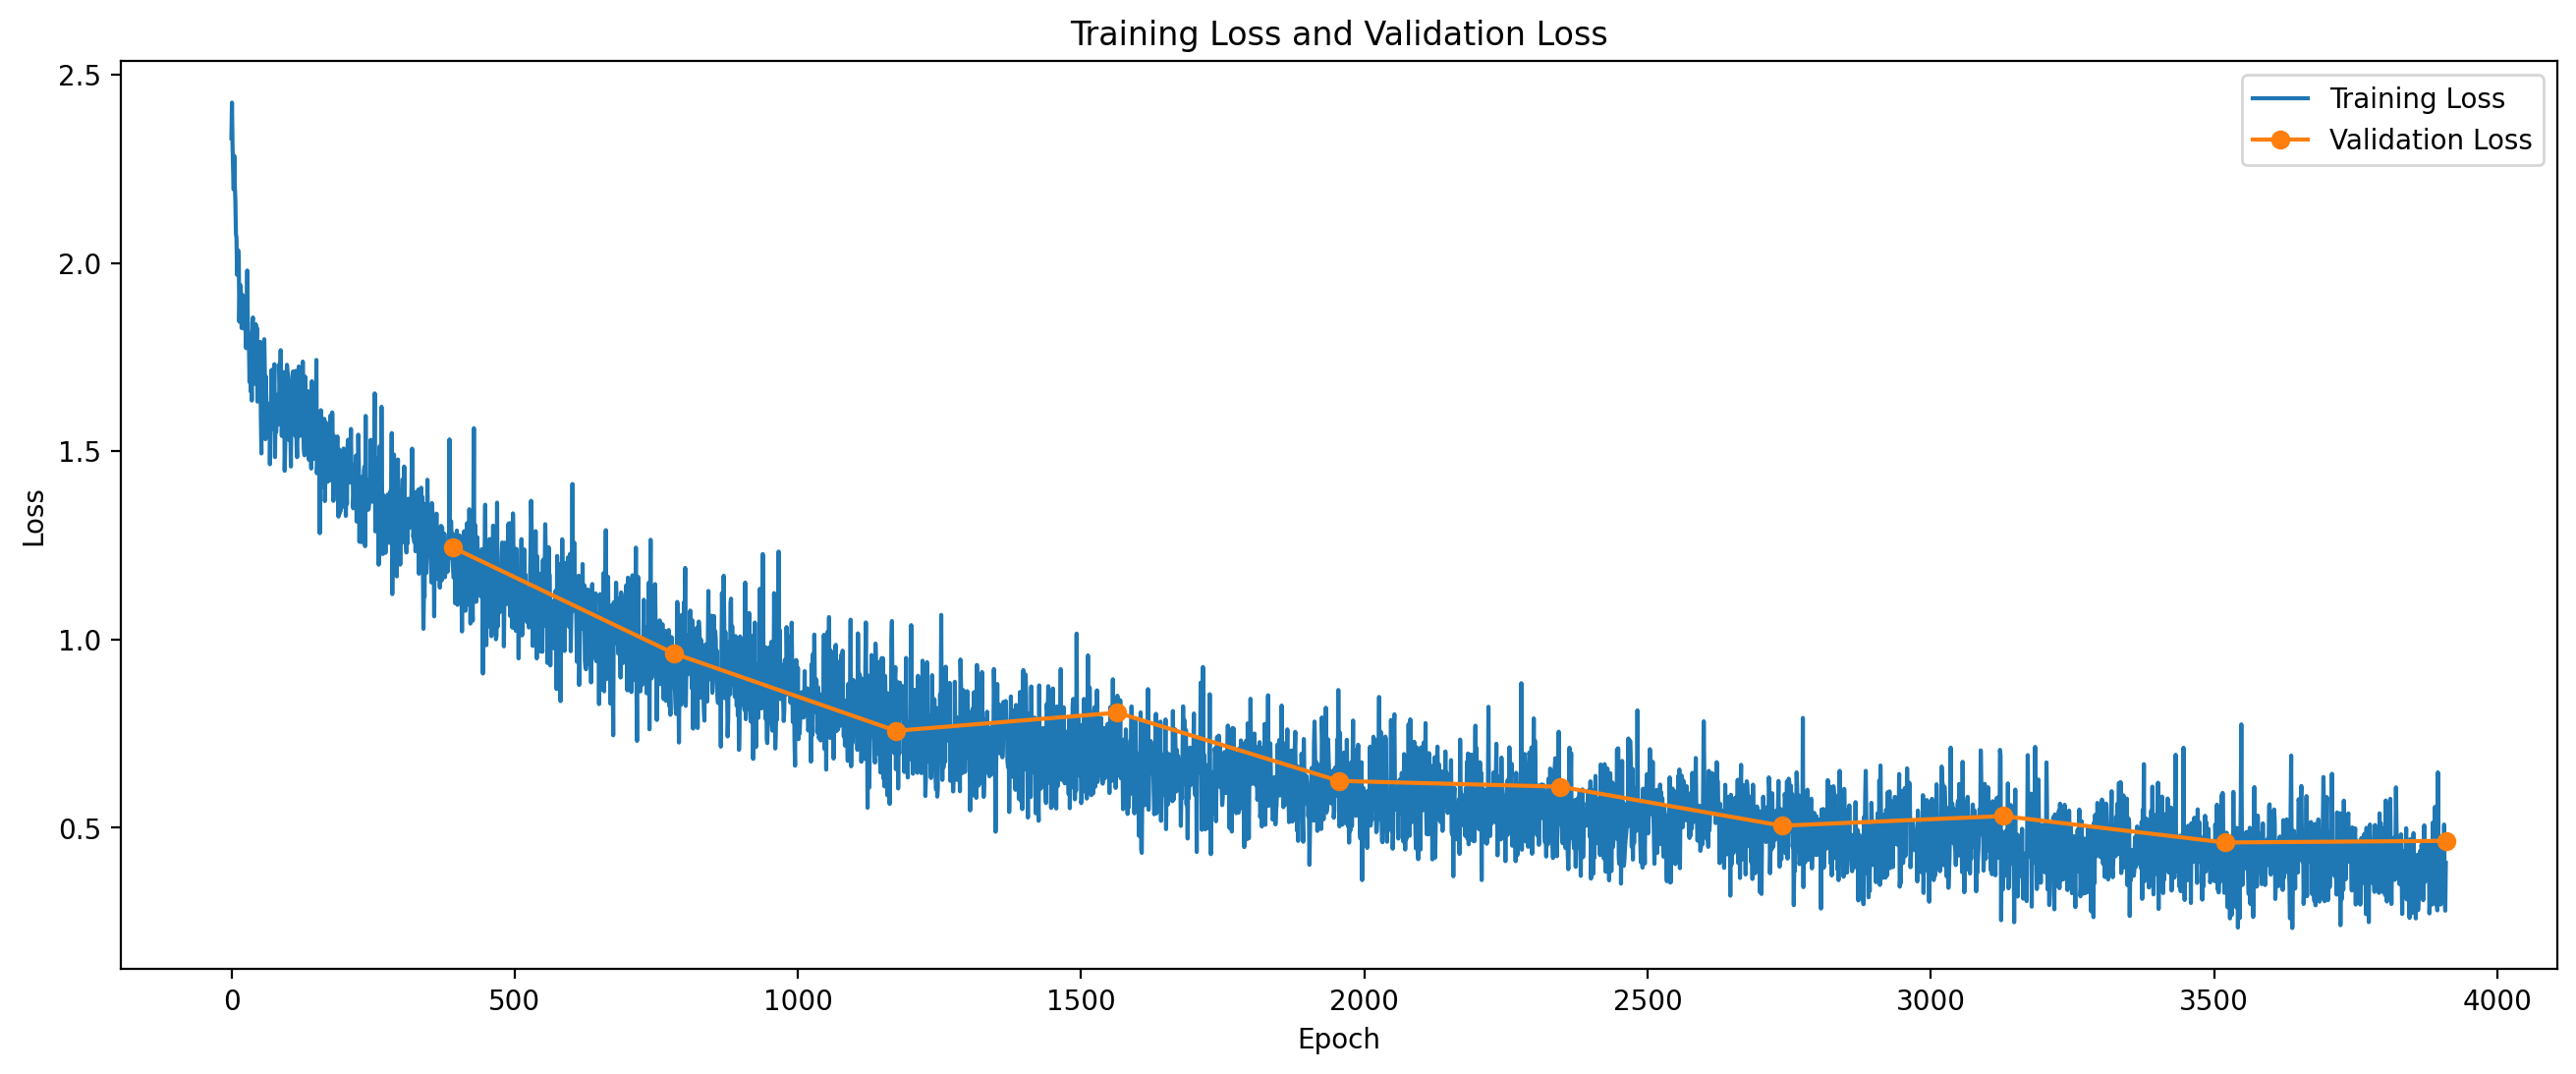

In [ ]:
start_train_time = time.time()
train_losses, val_losses = train(
    train_loader=train_loader_shuffle,
    val_loader=val_loader_no_shuffle,
    model=model,
    epochs=epochs,
    lr=lr
)
end_train_time = time.time()

start_val_time = time.time()
val_acc = get_acc(model, val_loader_no_shuffle)
end_val_time = time.time()

print('\nBatch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =, {:.2f}%'.format(val_acc * 100))
print("Process Training time: {:0.4f} s".format(end_train_time - start_train_time))
print("Process validation time: {:0.4f} s".format(end_val_time - start_val_time))

train_loader_length = len(train_loader_shuffle)
plot_losses(train_losses, val_losses, train_loader_length ,10)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


#### 1. Standard Convolution

In a standard convolution, the number of floating point operations (FLOPs) is calculated using the formula:  
FLOPs = K x K x Cin x Cout x H x W.  
Here, K x K is the filter size, Cin is the number of input channels, Cout is the number of output channels, and H x W is the size of the output feature map.

---

#### 2. Depthwise Separable Convolution

Depthwise separable convolutions divide the computation into two steps:

1. Depthwise Convolution: Applies a K x K filter to each input channel independently. The FLOPs for this step are calculated as K x K x Cin x H x W.  
2. Pointwise Convolution: Combines the outputs from the depthwise step using a 1 x 1 convolution. The FLOPs for this step are calculated as Cin x Cout x H x W.

The total FLOPs for depthwise separable convolution are the sum of these two steps:  
FLOPs_separable = (K x K x Cin x H x W) + (Cin x Cout x H x W).

---

#### 3. FLOPs Comparison

For example, let’s assume K = 3, Cin = 32, Cout = 64, and H = W = 112. For a standard convolution, the FLOPs are calculated as 3 x 3 x 32 x 64 x 112 x 112 = 207,360,000. For a depthwise separable convolution:

- Depthwise Convolution: FLOPs = 3 x 3 x 32 x 112 x 112 = 3,866,112.
- Pointwise Convolution: FLOPs = 32 x 64 x 112 x 112 = 25,165,824.

The total FLOPs for depthwise separable convolution are 3,866,112 + 25,165,824 = 29,031,936. The speedup factor is calculated as the ratio of standard convolution FLOPs to depthwise separable convolution FLOPs, which is 207,360,000 / 29,031,936 ≈ 7.14. For deeper architectures and across multiple layers, this speedup can increase to 8-9 times.

---

#### 4. Why Depthwise Separable Convolution is Faster

By dividing the convolution into depthwise and pointwise operations, depthwise separable convolutions reduce the number of computations significantly. This reduction in FLOPs leads to:

1. Fewer computations, resulting in faster execution.
2. Lower memory usage, which is ideal for mobile and embedded devices.
3. Improved efficiency for lightweight models.

---

Depthwise separable convolutions drastically reduce the computational cost compared to standard convolutions. This efficiency enables MobileNet to achieve a speedup of approximately 8-9x, as validated by the FLOPs calculations and real-world performance.


## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [ ]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()
        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),)
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [ ]:
# TODO: train model
epochs = 2
batch_size = 128
lr = 1e-3

normal_cnn_model = NormalCNN(n_class=10).to(device)
optimizer = torch.optim.Adam(normal_cnn_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
train_loader_shuffle = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_no_shuffle = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

start_train_time_CNN = time.time()
train_losses, val_losses = train(
    train_loader=train_loader_shuffle,
    val_loader=val_loader_no_shuffle,
    model=normal_cnn_model,
    epochs=epochs,
    lr=lr)
end_train_time_CNN = time.time()

start = time.time()
val_acc = get_acc(normal_cnn_model, val_loader_no_shuffle)
end = time.time()

print(f"train_loss: {train_losses[-1]:.4f} | val_loss: {val_losses[-1]:.4f} | val_acc: {val_acc:.4f}")

Epoch 1/2
Train Loss: 1.8728, Validation Loss: 1.6836
Epoch 2/2
Train Loss: 1.4218, Validation Loss: 1.5657
train_loss: 1.4218 | val_loss: 1.5657 | val_acc: 0.4585


Batch_size=128, epochs=2, lr=0.001
Val accuracy = 45.85%
Process Training Time: 639.6242 s
Process validation time: 23.0357 s


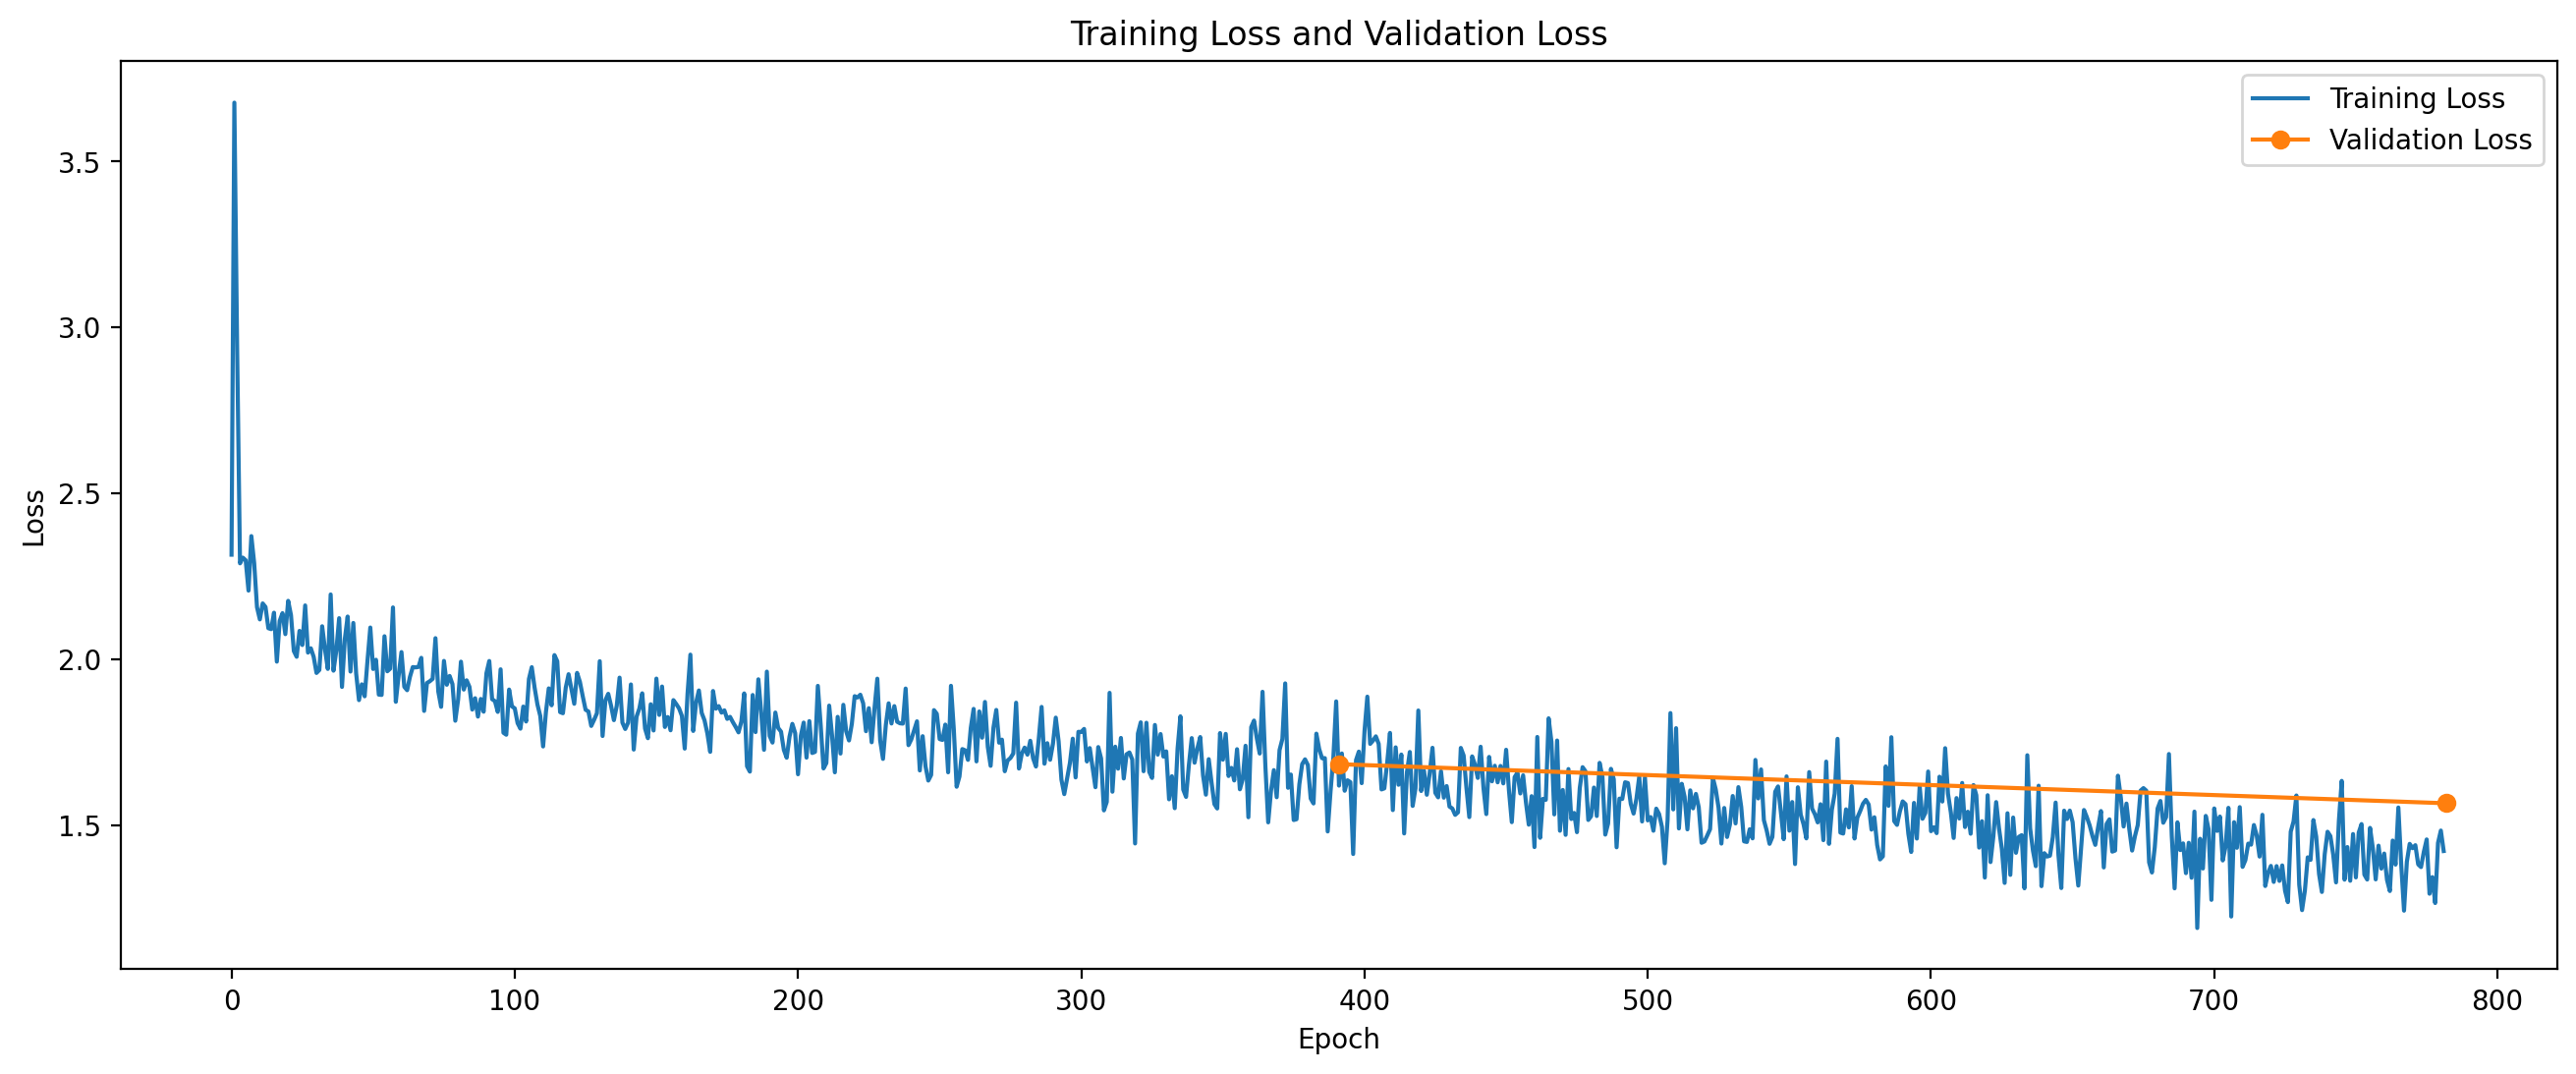

In [ ]:
print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy = {:.2f}%'.format(val_acc * 100))
print("Process Training Time: {:.4f} s".format(end_train_time_CNN - start_train_time_CNN))
print("Process validation time: {:.4f} s".format(end - start))
plot_losses(train_losses, val_losses, train_loader_length, 2)

Compare speed of learning and validating in normal CNN vs MobileNet

---
### **Comparison of Training and Validation Times**

---

#### **1. Total Training Time**

- **NormalCNN**: Takes significantly more time per epoch compared to MobileNet.
- **MobileNet**: Trains faster per epoch, benefiting from its lightweight architecture and reduced number of parameters.

**Conclusion**: MobileNet trains much faster than NormalCNN, highlighting its efficiency in processing data.

---

#### **2. Validation Process Time**

- **NormalCNN**: Validation takes longer due to the larger number of parameters and a more complex architecture.
- **MobileNet**: Validation is faster, reflecting its optimized structure.

**Conclusion**: MobileNet validates more quickly than NormalCNN, further emphasizing its architectural advantages.

---

#### **3. Overall Efficiency**

MobileNet showcases higher efficiency in both training and validation:
- **Training**: MobileNet trains significantly faster per epoch compared to NormalCNN, requiring much less time overall.
- **Validation**: MobileNet validates in noticeably less time, showing efficiency even during this less computationally intensive process.

---

MobileNet is considerably more efficient than NormalCNN in terms of both training and validation time. Its lightweight architecture, with fewer parameters and computational overhead, makes it ideal for scenarios requiring speed and efficiency, such as deployment on resource-constrained devices or time-sensitive applications.

In [ ]:
# TODO: compare number of parameters in these two models
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

normal_cnn_params = count_parameters(NormalCNN(n_class=10))
mobilenet_params = count_parameters(MobileNet(n_class=10))
print(f"Number of NormalCNN parameters: {normal_cnn_params}")
print(f"Number of MobileNet parameters: {mobilenet_params}")

Number of NormalCNN parameters: 28279338
Number of MobileNet parameters: 3217226


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [ ]:
model = MobileNet(n_class=100).to(device)
#Todo:
# Load the pre-trained weights for the layers that match (excluding the final fc layer)
pretrained_dict = torch.load('model.pt')

# Filter out unnecessary keys from the pretrained dict
model_dict = model.state_dict()
filtered_pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and model_dict[k].size() == v.size()}

# Load the updated state dict into the model
model_dict.update(filtered_pretrained_dict)
model.load_state_dict(model_dict)

<ipython-input-19-35553e615090>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load('model.pt')


<All keys matched successfully>

**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [ ]:
# Freeze up to the desired layer (e.g., the first 7 layers)
freeze_up_to = 'model.8'
for name, param in model.named_parameters():
    if freeze_up_to in name:
        break
    param.requires_grad = False

print(f"{'Layer':<40} {'Status':<10}")
print("----" * 10 )

for name, param in model.named_parameters():
    status = "Frozen" if not param.requires_grad else "Trainable"
    print(f"{name:<40} {status:<10}")

Layer                                    Status    
----------------------------------------
model.0.0.weight                         Frozen    
model.0.1.weight                         Frozen    
model.0.1.bias                           Frozen    
model.1.0.weight                         Frozen    
model.1.1.weight                         Frozen    
model.1.1.bias                           Frozen    
model.1.3.weight                         Frozen    
model.1.4.weight                         Frozen    
model.1.4.bias                           Frozen    
model.2.0.weight                         Frozen    
model.2.1.weight                         Frozen    
model.2.1.bias                           Frozen    
model.2.3.weight                         Frozen    
model.2.4.weight                         Frozen    
model.2.4.bias                           Frozen    
model.3.0.weight                         Frozen    
model.3.1.weight                         Frozen    
model.3.1.bias         

**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [ ]:
# TRAIN DATA
train_set100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
train_set100_no_aug = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train_no_aug)
indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)
train_set100_no_aug = Subset(train_set100_no_aug, indices)
train_loader100 = torch.utils.data.DataLoader(train_set100, batch_size=128, shuffle=False, num_workers=2)
train_loader100_no_aug = torch.utils.data.DataLoader(train_set100_no_aug, batch_size=128, shuffle=False, num_workers=2)

# VALIDATION DATA
val_set100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
val_loader100 = torch.utils.data.DataLoader(val_set100, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 169M/169M [04:09<00:00, 678kB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.

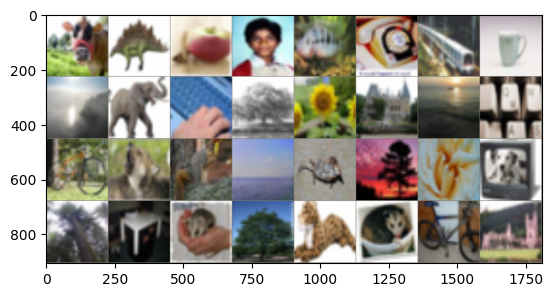

Labels are: tensor([19, 29,  0, 11,  1, 86, 90, 28, 23, 31, 39, 96, 82, 17, 71, 39,  8, 97,
        80, 71, 74, 59, 70, 87, 59, 84, 64, 52, 42, 64,  8, 17, 47, 65, 21, 22,
        81, 11, 24, 84, 78, 45, 49, 97, 56, 76, 11, 90, 89, 78, 73, 14, 87,  9,
        71,  6, 47, 20, 98, 47, 36, 55, 72, 43, 51, 35, 83, 33, 27, 53, 92, 50,
        15, 89, 36, 18, 89, 46, 33, 42, 39, 64, 75, 38, 23, 42, 66, 77, 49, 18,
        46, 15, 35, 69, 95, 83, 75, 99, 73, 93, 55, 39,  4, 97, 61, 93, 51, 69,
        56, 84, 59, 64, 94,  4, 11, 33, 68, 38, 20, 33, 34, 32, 46, 53, 88, 67,
        70, 64])


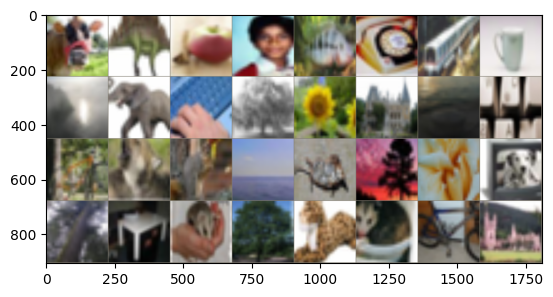

In [ ]:
# show some training images with shuffle=False and labels
data_iter = iter(train_loader100_no_aug)
images, labels = next(data_iter)
grid_img = torchvision.utils.make_grid(images[:32], nrow=8)
imshow(grid_img)
print("Labels are:", labels)

# show them again to check the augmentation
data_iter = iter(train_loader100)
images, labels = next(data_iter)
grid_img_2 = torchvision.utils.make_grid(images[:32], nrow=8)
imshow(grid_img_2)

Do CIFAR10 and CIFAR100 use the same images but with diffrent labesl?(maybe you should search)

---
CIFAR-10 and CIFAR-100 are two distinct datasets derived from the larger "80 Million Tiny Images" dataset, but they do not share the same images. CIFAR-10 consists of 60,000 images divided into 10 classes, each containing 6,000 images, with non-overlapping categories such as airplanes, cars, and birds. In contrast, CIFAR-100 also comprises 60,000 images but is divided into 100 finer-grained classes, each with 600 images. The labeling structure of CIFAR-100 is more complex, organizing its 100 classes into 20 superclasses, with each image assigned both a fine label (specific class) and a coarse label (corresponding superclass). Importantly, there is no overlap between the image sets of CIFAR-10 and CIFAR-100, making the two datasets entirely independent despite sharing a common origin. CIFAR-10’s simplicity makes it suitable for general image classification tasks, while CIFAR-100 offers a more challenging dataset with its hierarchical label structure and detailed categorization.

Now train your model using your functions.

In [ ]:
epochs = 7
lr = 2e-4
train_losses, val_losses = train(train_loader100, val_loader100, model, epochs, lr)

Epoch 1/7
Train Loss: 4.1562, Validation Loss: 4.0978
Epoch 2/7
Train Loss: 3.9877, Validation Loss: 3.8766
Epoch 3/7
Train Loss: 3.7857, Validation Loss: 3.7374
Epoch 4/7
Train Loss: 3.6782, Validation Loss: 3.6909
Epoch 5/7
Train Loss: 3.3993, Validation Loss: 3.5617
Epoch 6/7
Train Loss: 3.3287, Validation Loss: 3.4757
Epoch 7/7
Train Loss: 3.3492, Validation Loss: 3.4258


Get some metrics and plot your losses.

Batch_size=128, epochs=7, lr=0.0002
Val accuracy 17.99%
Process validation time: 19.5591 s


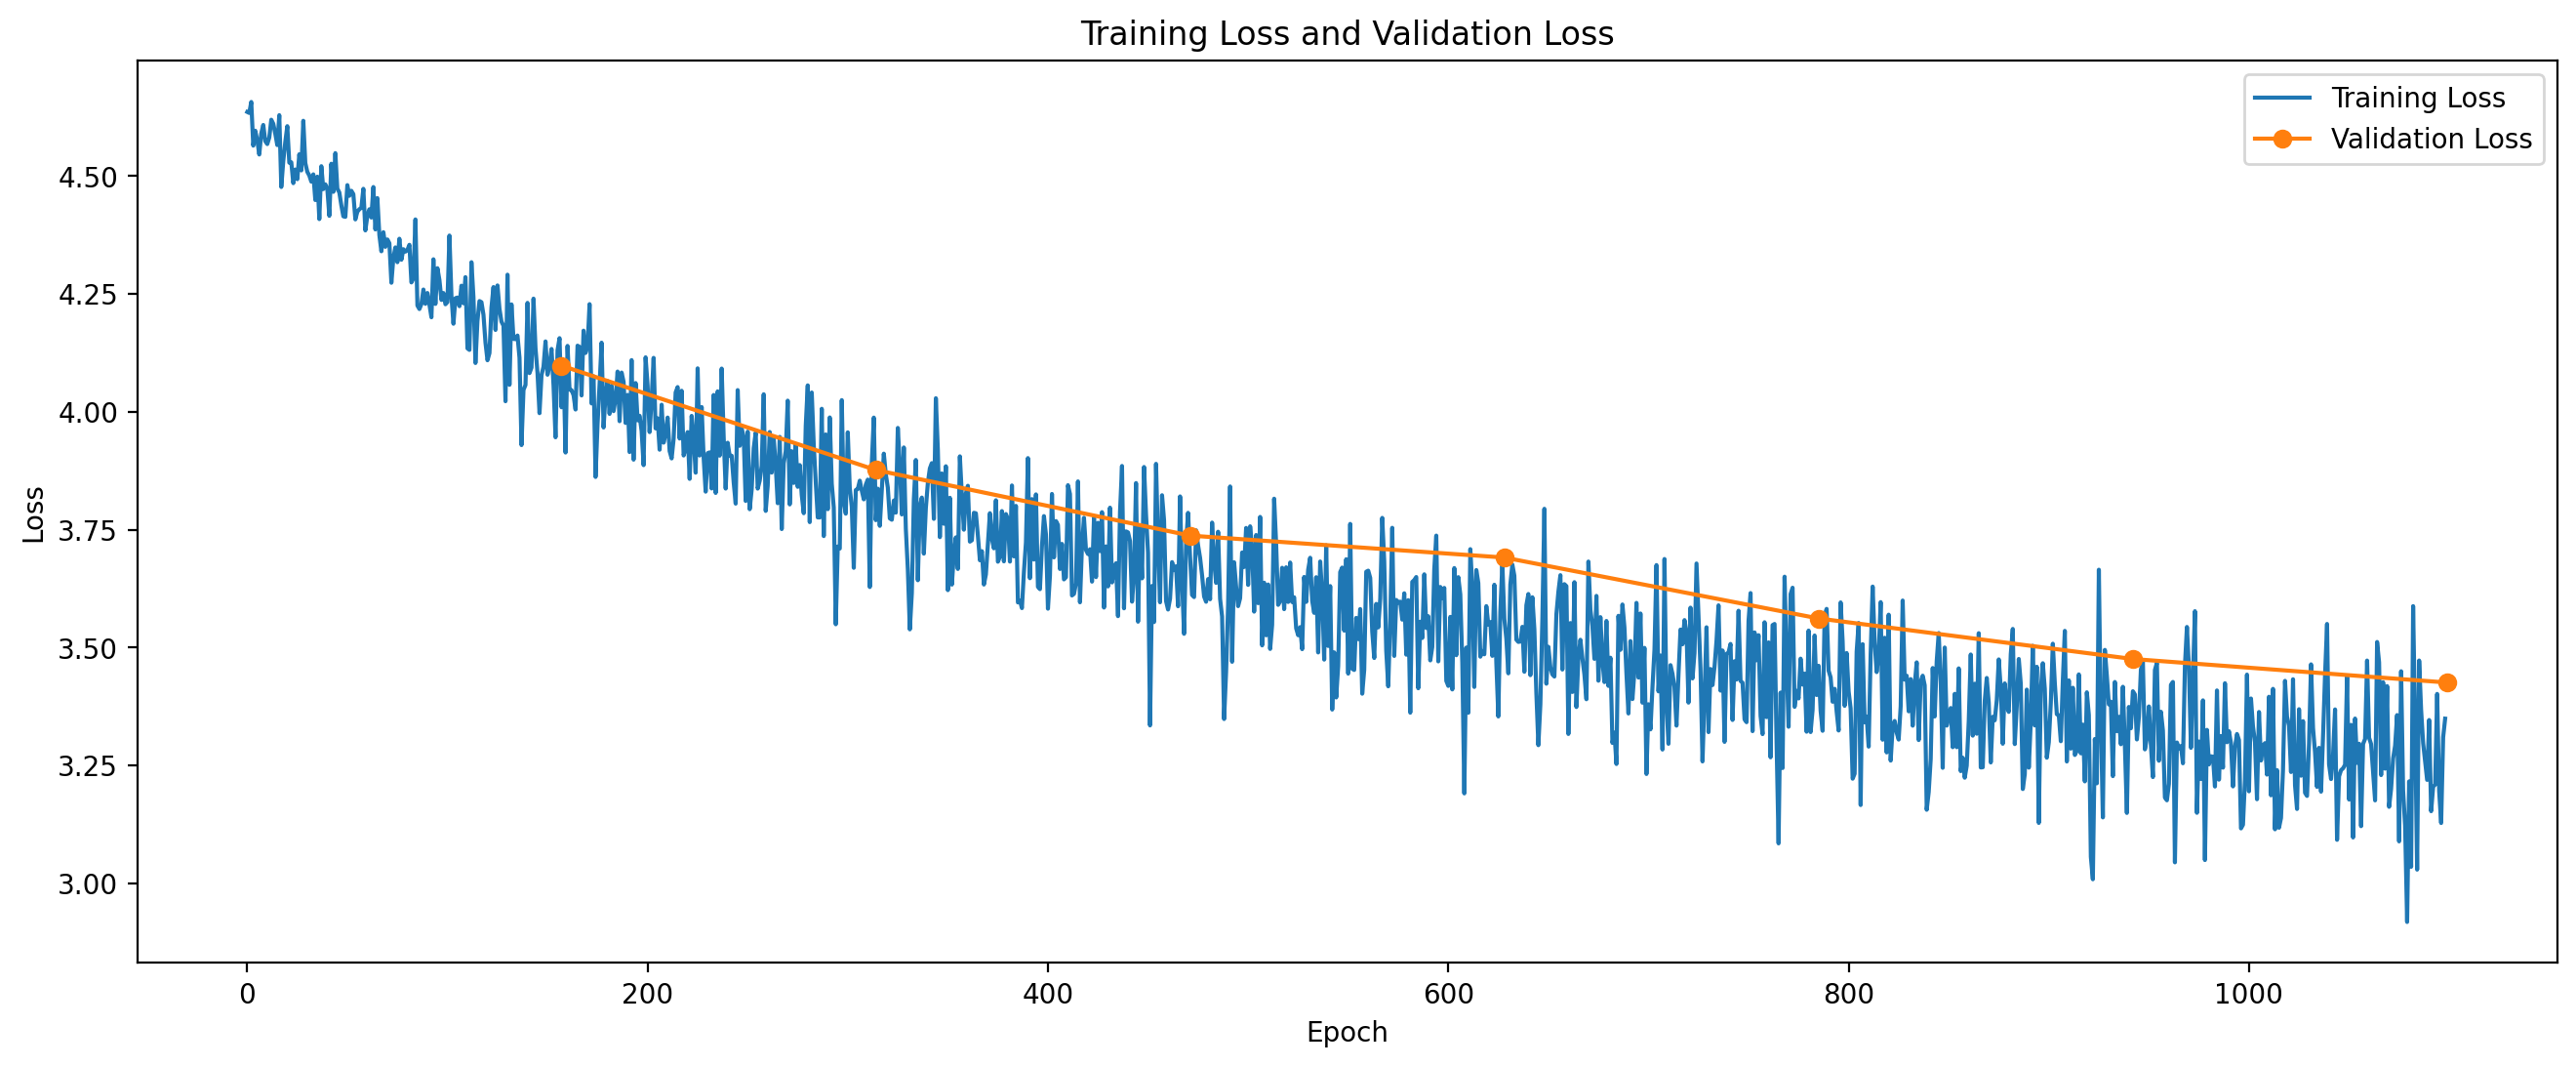

In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader100)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy {:.2f}%'.format(val_acc * 100))
print("Process validation time: {:0.4f} s".format(end - start))

train_loader_length = len(train_loader100)
plot_losses(train_losses, val_losses, train_loader_length ,7)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now where are going to implement the model. First complete the below functions and class.

What is ReLU6 Activation Function? Why do we use that?

---

### **What is the ReLU6 Activation Function?**

ReLU6 is a modified version of the standard ReLU (Rectified Linear Unit) activation function. While ReLU outputs values from 0 to infinity for positive inputs, ReLU6 limits the output to a maximum value of 6. The mathematical representation of ReLU6 is:

`f(x) = min(max(0, x), 6)`

---

### **Why Do We Use ReLU6?**

ReLU6 is particularly useful in scenarios where computational efficiency and numerical stability are critical, such as mobile and edge devices. Below are the key advantages:

1. **Bounded Output for Stability:**
   - The cap at 6 limits the range of activation values, reducing the risk of exploding gradients and numerical instability during training. This is especially important in low-precision computation environments (e.g., 8-bit quantization).

2. **Improved Performance in Quantized Models:**
   - ReLU6 is designed to work well with **quantized neural networks** (like in MobileNet). By capping the activations, it ensures smoother transitions between floating-point and integer representations, leading to better performance in hardware-accelerated environments.

3. **Mitigation of Overly Large Activations:**
   - Large activations can lead to inefficient use of computational resources. ReLU6 prevents excessively high activations, optimizing resource usage during inference.

4. **Compatibility with Lightweight Architectures:**
   - Models like MobileNet often use ReLU6 because it fits well with their compact, efficient design philosophy. The bounded nature ensures better behavior under constrained resources without significantly impacting model performance.

---

### **Applications**

ReLU6 is widely used in deep learning models optimized for mobile and embedded devices, such as:
- **MobileNet**
- **EfficientNet**
- Other lightweight architectures tailored for resource-constrained environments.

Its design aligns well with scenarios requiring quantization and efficient computation while maintaining competitive accuracy.

In [ ]:
def conv_bn(inp, oup, stride):
    # Standard convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    # stride: stride for the convolution layer
    layers = [
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    ]
    return nn.Sequential(*layers)


def conv_1x1_bn(inp, oup):
    # 1x1 pointwise convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    layers = [
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    ]
    return nn.Sequential(*layers)


class InvertedResidual(nn.Module):
    # Inverted Residual block with optional skip connection
    # inp: input channels
    # oup: output channels
    # stride: stride for depthwise convolution
    # expand_ratio: multiplier for the hidden dimension size

    # Determine if a skip connection should be used
    # (only used when stride is 1 and input channels == output channels)
    # Calculate the number of hidden channels after expansion

    def __init__(self, inp, oup, stride, expand_ratio):
        super().__init__()
        self.use_residual = (stride == 1 and inp == oup)
        hidden_dim = int(inp * expand_ratio)

        # Build the block layers
        block = []
        if expand_ratio != 1:
            block.extend([
                nn.Conv2d(inp, hidden_dim, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True)
            ])

        block.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride,
                      padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(oup)
        ])

        self.conv = nn.Sequential(*block)

    def forward(self, x):
        """
        Forward pass of the block.
        Args:
            x (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Output tensor.
        """
        # Forward pass with optional residual connection
        return x + self.conv(x) if self.use_residual else self.conv(x)


Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [ ]:
class MobileNetV2(nn.Module):
    def __init__(self, n_class=10, width_multiplier=0.5):
        """
        Initializes the MobileNetV2 architecture.

        Args:
            n_class (int): Number of output classes.
            width_multiplier (float): Width multiplier to control model size.
        """
        super(MobileNetV2, self).__init__()

        # Configuration of inverted residual blocks [t, c, n, s]
        interverted_residual_setting = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1]
        ]

        # Building the first convolutional layer
        input_channel = max(1, int(32 * width_multiplier))
        self.last_channel = max(1, int(1280 * width_multiplier))
        self.features = nn.ModuleList([conv_bn(3, input_channel, stride=2)])

        # Building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = max(1, int(c * width_multiplier))
            for i in range(n):
                stride = s if i == 0 else 1
                self.features.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel

        # Adding the final layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        self.features.append(nn.AdaptiveAvgPool2d(1))

        # Convert the features to a sequential container
        self.features = nn.Sequential(*self.features)

        # Building the classifier
        self.classifier = nn.Linear(self.last_channel, n_class)

    def forward(self, x):
        """
        Forward pass of the MobileNetV2 model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor with class scores.
        """
        x = self.features(x)  # Pass through feature extractor
        x = x.view(x.size(0), -1)  # Flatten to prepare for classification
        x = self.classifier(x)  # Pass through classifier
        return x

How did you create linear bottlenecks? How do they help?

---
Linear bottlenecks are a critical innovation in efficient neural network architectures, such as MobileNetV2, designed to reduce computational costs without sacrificing performance. A linear bottleneck is created by combining several layers: first, an expansion layer using a pointwise \(1x1) convolution increases the dimensionality of the input feature map, allowing for richer representations. This is followed by a depthwise convolution that applies a spatial filter independently to each channel, significantly lowering computational demands. The key feature of the linear bottleneck is that it uses a linear activation function, rather than a non-linear one like ReLU, to reduce the dimensionality of the feature maps in a more compact form. This preserves the essential structure of the data while reducing the number of operations and parameters in the model.

The use of linear bottlenecks helps in several ways. They improve model efficiency by decreasing the number of computations and parameters, making the model lighter and faster, especially useful in mobile and edge devices. The linearity ensures that important features are preserved through the bottleneck, avoiding information loss that can occur with non-linear activations. Moreover, linear bottlenecks contribute to better gradient flow, which can enhance training stability. The design is also compatible with quantization techniques, which are critical for deploying models in hardware-constrained environments. This architecture is foundational to models like MobileNetV2 and EfficientNet, which are tailored for real-time applications with limited computational resources, balancing both model size and accuracy effectively.

Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [ ]:
model = MobileNetV2(n_class=10).to(device)
epochs = 10
lr = 1e-3
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)


Epoch 1/10
Train Loss: 1.2559, Validation Loss: 1.5370
Epoch 2/10
Train Loss: 0.9033, Validation Loss: 1.1380
Epoch 3/10
Train Loss: 0.9878, Validation Loss: 1.1051
Epoch 4/10
Train Loss: 1.0806, Validation Loss: 0.9888
Epoch 5/10
Train Loss: 0.7259, Validation Loss: 0.8919
Epoch 6/10
Train Loss: 0.6166, Validation Loss: 0.8195
Epoch 7/10
Train Loss: 0.8189, Validation Loss: 0.8315
Epoch 8/10
Train Loss: 0.6069, Validation Loss: 0.7856
Epoch 9/10
Train Loss: 0.4971, Validation Loss: 0.6962
Epoch 10/10
Train Loss: 0.3843, Validation Loss: 0.6992


Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy 75.78%
Process validation time: 19.4042 s


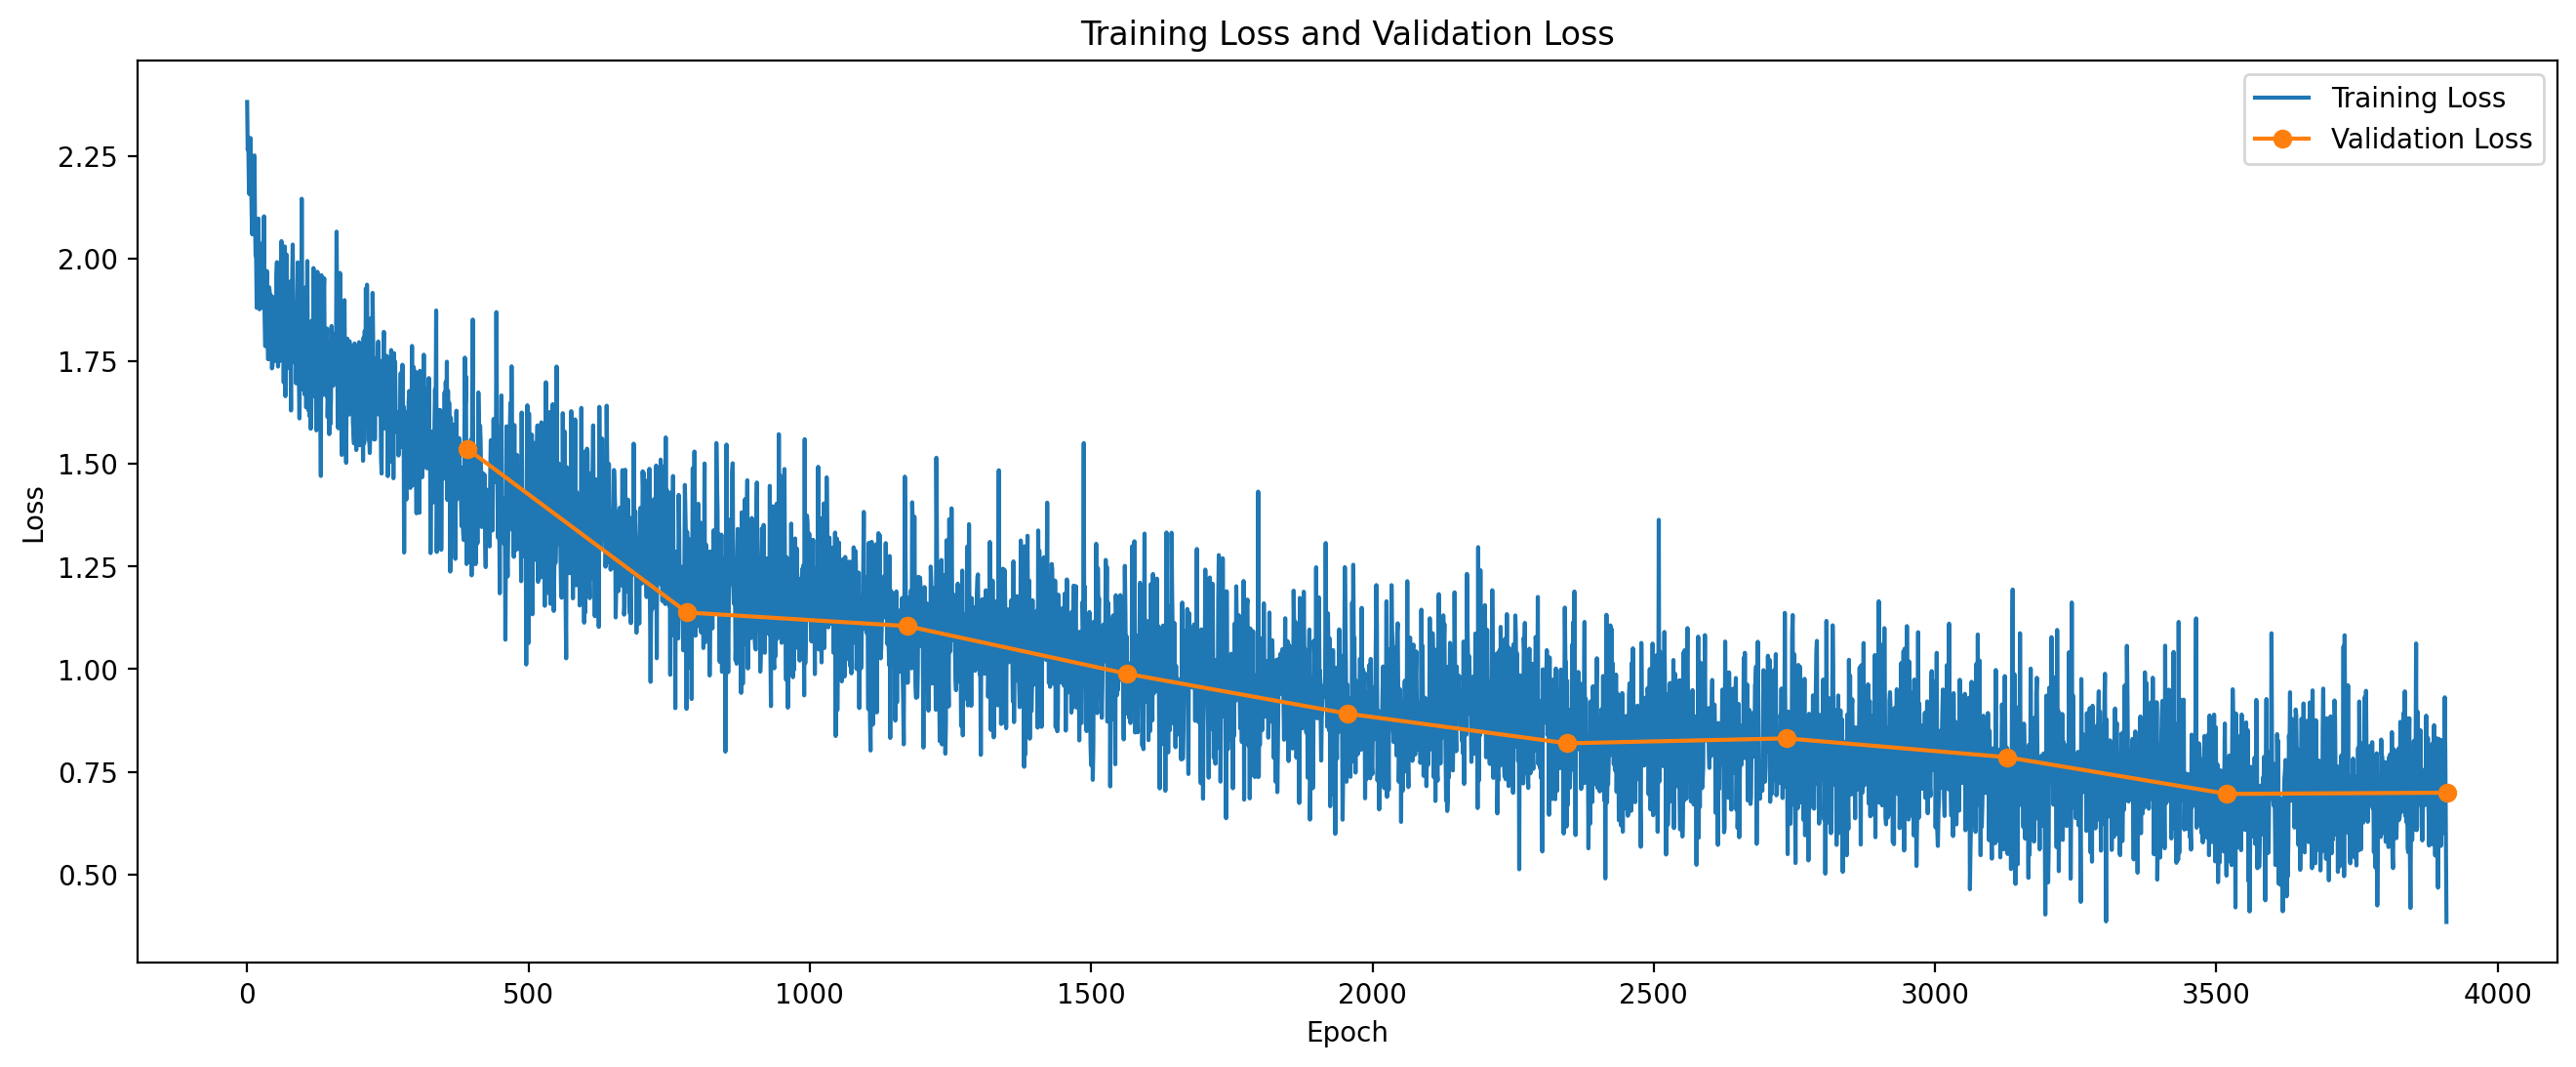

In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy {:.2f}%'.format(val_acc * 100))
print("Process validation time: {:0.4f} s".format(end - start))

train_loader_length = len(train_loader)
plot_losses(train_losses, val_losses, train_loader_length ,10)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [ ]:
# TODO
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for width_multiplier in [round(x, 1) for x in torch.arange(0.1, 1.1, 0.1).tolist()]:
    mobilenetv2_model = MobileNetV2(n_class=10, width_multiplier=width_multiplier).to(device)
    num_params = count_parameters(mobilenetv2_model)
    print(f"with {width_multiplier:.1f} width multipier we got {num_params} parameters")

with 0.1 width multipier we got 31255 parameters
with 0.2 width multipier we got 105224 parameters
with 0.3 width multipier we got 221676 parameters
with 0.4 width multipier we got 380438 parameters
with 0.5 width multipier we got 587178 parameters
with 0.6 width multipier we got 826943 parameters
with 0.7 width multipier we got 1113168 parameters
with 0.8 width multipier we got 1441788 parameters
with 0.9 width multipier we got 1812806 parameters
with 1.0 width multipier we got 2236682 parameters


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [ ]:
MNv2_path = './MNv2WMmodel.pt'
# TODO
model = MobileNetV2(n_class=10, width_multiplier=0.5).to(device)
model.load_state_dict(torch.load(MNv2_path))

<ipython-input-35-97a4833fd056>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MNv2_path))


<All keys matched successfully>

In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Val accuracy = {:.2f}%'.format(val_acc * 100))
print("Process validation time: {:0.4f} s".format(end - start))

Val accuracy = 74.32%
Process validation time: 18.0792 s


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

---

To understand how a specific hyperparameter (such as kernel size or the number of output channels) affects the number of parameters in a neural network, we can look at the formulas that predict these changes. In a convolutional layer, the number of parameters is calculated by considering the size of the kernel, the number of input channels, and the number of output channels. The basic formula for a standard convolution is:

\[
\text{Parameters} = K \times K \times C_{in} \times C_{out} + C_{out}
\]

Where:
- \(K\) is the kernel size (e.g., \(3 \times 3\) or \(5 \times 5\)),
- \(C_{in}\) is the number of input channels,
- \(C_{out}\) is the number of output channels,
- The term \(C_{out}\) accounts for the biases associated with each output channel.

In the case of **depthwise separable convolutions** (used in models like MobileNet), the operation is divided into two parts:
1. **Depthwise Convolution:** Each input channel has its own filter, and the number of parameters is:
   
\[
\text{Depthwise Parameters} = K \times K \times C_{in}
\]

2. **Pointwise Convolution:** A \(1 \times 1\) convolution is applied to combine the features, and the parameters for this are:

\[
\text{Pointwise Parameters} = C_{in} \times C_{out}
\]

Thus, the total number of parameters in a depthwise separable convolution is the sum of the depthwise and pointwise parameters:

\[
\text{Total Parameters} = (K \times K \times C_{in}) + (C_{in} \times C_{out})
\]

For example, let's consider a case where:
- \(K = 3\),
- \(C_{in} = 32\),
- \(C_{out} = 64\).

**In a standard convolution**, the number of parameters is:

\[
\text{Parameters} = 3 \times 3 \times 32 \times 64 + 64 = 18,432 + 64 = 18,496
\]

**In a depthwise separable convolution**, the number of parameters would be:

- Depthwise Parameters: \(3 \times 3 \times 32 = 288\),
- Pointwise Parameters: \(32 \times 64 = 2,048\),
- Total Parameters: \(288 + 2,048 = 2,336\).

This shows that the depthwise separable convolution reduces the number of parameters by approximately **87%** compared to the standard convolution, which can be predicted using the formulas above.

While the theoretical formulas provide a good estimate, there might be slight discrepancies between the predicted and actual number of parameters due to additional factors. For example, biases might be handled differently across implementations, or the presence of padding and strides can affect the output size, indirectly impacting the number of parameters. Additionally, certain optimizations in model design can further reduce the effective parameter count, especially in mobile or embedded architectures. Despite these nuances, the formulas offer a strong foundation for predicting the parameter count in different layers of a neural network.

---

Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

---
The **resolution multiplier** is a hyperparameter that affects the input image size or the resolution of the feature maps throughout the network. By adjusting this multiplier, we scale the size of the images and consequently the network’s layers.

### **Impact on Model Speed:**

Yes, using a **lower resolution multiplier** can make the model faster. This is because when the input resolution decreases, the number of computations required for processing the images in each layer also decreases. Convolution operations are performed over smaller spatial regions, which results in fewer activations and therefore faster computations. This can be particularly useful for **mobile devices** or **real-time applications** where processing speed is crucial.

### **Impact on the Number of Parameters:**

The resolution multiplier generally **does not directly affect the number of parameters** in the model itself, but it **does influence the size of intermediate feature maps**. When the resolution is reduced, each layer in the network operates on a smaller spatial grid, leading to fewer activations and outputs at each layer. As a result:
- The number of computations (multiplications and additions) required during training and inference is reduced.
- The number of parameters, particularly those tied to spatial dimensions (e.g., convolutional filters), remains the same, but the number of operations per filter decreases due to smaller input sizes at each layer.

To summarize, while the resolution multiplier **does not decrease the number of parameters** directly, it **reduces the computational load** by decreasing the size of intermediate feature maps, making the model faster. This is a typical trade-off in model design, where you balance speed, computational efficiency, and accuracy. Models like **MobileNet** use this strategy (along with others) to optimize both performance and resource consumption.

In terms of model architectures like **MobileNet**, the resolution multiplier is often used as part of the overall approach to create lightweight networks, ensuring a good balance between speed and accuracy. For instance, a resolution multiplier of 0.75 would reduce the size of each input image and thus the amount of computation, but it could also slightly lower the model's accuracy since less detailed information is processed.

---

Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

---
The number of parameters in a neural network remains an important factor even with the advent of powerful GPUs for several reasons. While GPUs significantly accelerate the training and inference of models, the number of parameters still plays a critical role in various aspects of model efficiency, deployment, and overall system performance.

### **1. Memory Usage:**

Even with fast GPUs, the number of parameters affects the **memory usage** of a model. A large model with millions or billions of parameters requires a substantial amount of GPU memory (VRAM) to store the model weights and intermediate activations during both training and inference. This can become a bottleneck, especially on devices with limited GPU resources, such as mobile devices, embedded systems, or cloud-based services with memory limits. Reducing the number of parameters can make the model more memory-efficient, enabling it to fit within smaller memory budgets and potentially reducing costs when deploying on cloud services where memory usage is billed.

### **2. Training Time:**

Although modern GPUs are designed to handle large models efficiently, the **training time** can still be influenced by the number of parameters. More parameters mean more weights to update during each backpropagation step. While GPUs can accelerate matrix operations, models with too many parameters will still take longer to train due to the sheer number of operations. In practice, increasing the number of parameters disproportionately increases training time, as the computational resources must perform more calculations and manage more data.

### **3. Overfitting:**

A high number of parameters can lead to **overfitting**, especially when the training dataset is small or not sufficiently diverse. With more parameters, the model has greater capacity to memorize the training data, but it may fail to generalize to unseen data, resulting in poor performance on test sets. By reducing the number of parameters, we can enforce a model with simpler structures, which may help improve generalization and prevent overfitting.

### **4. Inference Speed:**

The **inference speed**—how quickly a model makes predictions—is also influenced by the number of parameters. A model with more parameters typically requires more computation during inference, leading to slower response times. In applications like real-time object detection, speech recognition, or autonomous driving, inference speed is critical. Thus, reducing the number of parameters can improve the model's deployment efficiency, especially in latency-sensitive environments.

### **5. Energy Efficiency:**

Models with fewer parameters often consume less power during training and inference. For mobile or edge devices, energy efficiency is crucial. Large models that require significant computational resources can drain battery life quickly, making them unsuitable for applications that need to run for extended periods on battery-powered devices. Reducing the model's size can therefore result in more power-efficient operations.

### **6. Scalability:**

Lastly, the number of parameters is essential for **scalability**. If a model is too large, scaling it across multiple devices or even across distributed systems can become challenging. Managing, updating, and storing the model parameters in a distributed setting can introduce overheads. Smaller models are easier to scale efficiently and can be deployed more easily on a range of devices with varying computational capabilities.

### **Conclusion:**

In summary, while GPUs indeed offer substantial performance improvements, the number of parameters in a neural network still affects several crucial factors such as memory usage, training time, overfitting, inference speed, energy efficiency, and scalability. Even with the power of modern GPUs, keeping the number of parameters optimized remains essential for ensuring efficient deployment and operation of neural networks across various environments, especially in resource-constrained scenarios like mobile devices, embedded systems, and large-scale cloud infrastructures. Therefore, reducing the number of parameters continues to be a significant factor in designing practical and efficient deep learning models.

## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for out task, but because of lack of resources we will just use it with terrible accuracy)

In [ ]:
import timm

# Load a pre-trained ResNet18 fine-tuned on CIFAR-10
teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
start = time.time()
val_acc = get_acc(teacher_model, val_loader)
end = time.time()

print('Val accuracy = {:.2f}%'.format(val_acc * 100))
print("Process validation time: {:0.4f} s".format(end - start))

Val accuracy = 6.18%
Process validation time: 19.8943 s


Now create a mobilenetv2 model and then write the code to train it with Knowledge Distillation.

In [ ]:
class DistillationLoss(nn.Module):
    """
    Custom loss function for knowledge distillation combining KL divergence
    and cross-entropy loss.

    Args:
        temperature (float): Temperature parameter for scaling logits.
        alpha (float): Weighting factor for distillation and classification loss.
    """
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction='batchmean')
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits: torch.Tensor, teacher_logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Compute the combined distillation and classification loss.

        Args:
            student_logits (torch.Tensor): Logits from the student model.
            teacher_logits (torch.Tensor): Logits from the teacher model.
            labels (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: The computed loss value.
        """
        scaled_student_logits = nn.functional.log_softmax(student_logits / self.temperature, dim=1)
        scaled_teacher_logits = nn.functional.softmax(teacher_logits / self.temperature, dim=1)
        distillation_loss = self.kl_div(scaled_student_logits, scaled_teacher_logits) * (self.temperature ** 2)
        classification_loss = self.ce_loss(student_logits, labels)
        return self.alpha * distillation_loss + (1 - self.alpha) * classification_loss


def train_student(teacher: nn.Module, student: nn.Module, train_loader: DataLoader, test_loader: DataLoader,
                  device: torch.device, epochs: int = 10, lr: float = 0.01) -> None:
    """
    Train a student model using knowledge distillation.

    Args:
        teacher (nn.Module): Pre-trained teacher model.
        student (nn.Module): Student model to train.
        train_loader (DataLoader): DataLoader for training data.
        test_loader (DataLoader): DataLoader for test data.
        device (torch.device): Device to perform training on (CPU or GPU).
        epochs (int): Number of training epochs. Default is 10.
        lr (float): Learning rate for the optimizer. Default is 0.01.
    """
    teacher.to(device).eval()
    student.to(device)
    criterion = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)

    for epoch in range(epochs):
        student.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                teacher_logits = teacher(inputs)
            student_logits = student(inputs)
            loss = criterion(student_logits, teacher_logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_train_loss:.4f}")
        student.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student(inputs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy: {accuracy:.2f}%")


Train it for one epoch to just check if it works.

In [ ]:
student = MobileNetV2(n_class=10)
train_student(teacher_model, student, train_loader, val_loader, device, epochs=1, lr=0.001)

Epoch 1/1, Loss: 1.0226347623273844
Test Accuracy: 43.33%


What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?

---
The **alpha (α)** hyperparameter in the DistillationLoss function plays a crucial role in determining how much emphasis is placed on the teacher model's soft targets (predictions) versus the true labels (hard targets). The choice of alpha significantly impacts the **alignment** of the student model with the teacher's knowledge and its **generalization** ability to perform well on the target task.

### **High Alpha (e.g., 0.9):**
When alpha is high, the student model is more influenced by the teacher's soft targets. This means the student is encouraged to learn the probabilities assigned by the teacher across all classes, not just the correct class, allowing it to capture the finer nuances of the teacher's decision-making process. This can help the student model to perform better in tasks where **teacher knowledge** is rich and beneficial. The student model essentially learns a more refined version of the task, similar to the teacher's performance. However, this comes with a potential **trade-off**: the student may become overly focused on imitating the teacher, potentially at the expense of learning directly from the **true data distribution**. This could lead to **overfitting** or poorer generalization if the teacher model is overfit or suboptimal for new, unseen data.

In essence, high alpha strengthens the alignment between the student and teacher, but may hinder the student’s ability to generalize well if the teacher’s knowledge doesn't transfer well to the task at hand.

### **Low Alpha (e.g., 0.1):**
With a lower alpha, the student model is more focused on the **hard labels** (true data), meaning it prioritizes learning directly from the correct class labels rather than mimicking the teacher’s predictions. This approach can enhance **generalization** because the student learns to recognize the true patterns in the data without being overly constrained by the teacher's potentially biased or suboptimal knowledge. This is particularly beneficial when the task involves new or unseen data that differs from what the teacher has been trained on. However, the downside is that the student may miss out on the teacher’s **valuable insights** and the more refined patterns captured by the teacher model. This could result in the student underperforming in cases where the teacher's knowledge offers important guidance.

Thus, a lower alpha allows the student model to be more independent, potentially improving its ability to generalize, but at the cost of losing some of the teacher’s expertise.

### **Conclusion:**
The choice of alpha represents a trade-off between **alignment** with the teacher’s knowledge and **generalization** to the task-specific data. A high alpha places more weight on the teacher’s predictions, making the student model more aligned with the teacher but potentially hindering generalization. A low alpha focuses more on the true labels, helping the student generalize better to unseen data, but may reduce the model’s alignment with the teacher’s learned representations.

Finding the optimal value of alpha depends on the nature of the task and the relative importance of imitating the teacher versus learning from the true labels. This balance can be fine-tuned for different applications, such as deploying models in resource-constrained environments or tasks requiring high accuracy on new data.

## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.
- **MobileNet V2**: Added inverted residuals and linear bottlenecks to improve efficiency and performance, reducing memory use without sacrificing accuracy.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018